<a href="https://colab.research.google.com/github/wenfeng7k/pytorch_models/blob/main/binary_class_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import torch


In [26]:
sample_size=1000
X, y = make_moons(n_samples = 1000,
                  noise=0.3,
                  random_state=42)

X[:5],y[:5]

(array([[-0.17186341,  0.59624885],
        [ 1.25328273, -0.26541353],
        [ 0.72322405,  0.2319425 ],
        [-0.06519764, -0.65519443],
        [-0.79949325,  0.55293543]]),
 array([1, 1, 1, 1, 0]))

In [27]:
import torch
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

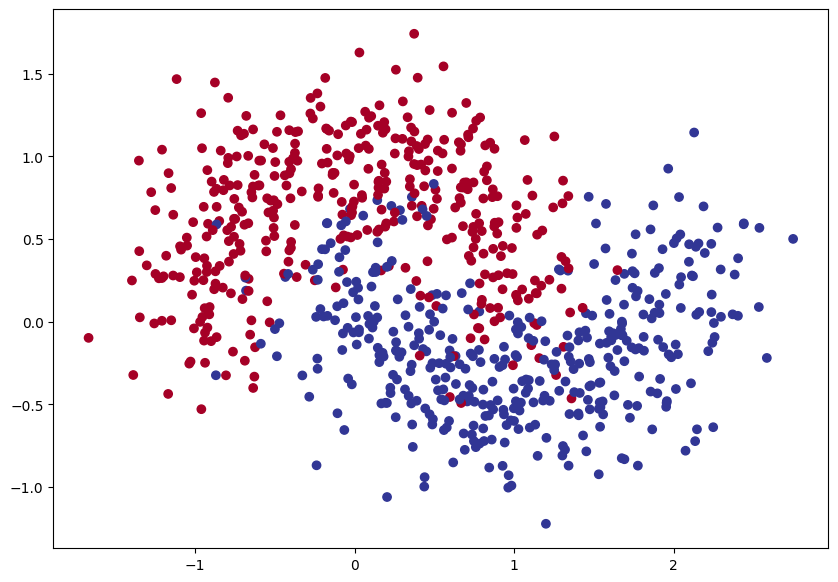

In [29]:
#Plot
plt.figure(figsize=(10,7))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap=plt.cm.RdYlBu)

In [30]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [34]:
from torch import nn
NUM_FEATURES=2
NUM_CLASSES=2
hidden_units=5
class MoonModel(nn.Module):
  def __init__(self, input_features,output_features,hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)
model_0=MoonModel(input_features=NUM_FEATURES,
                  output_features=1,
                  hidden_units=hidden_units).to(device)
model_0

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [35]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)


In [36]:
untrained_pred=model_0(X_test.to(device))
untrained_pred.shape,y_test.shape

(torch.Size([200, 1]), torch.Size([200]))

In [37]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [41]:
#Fit the model
torch.manual_seed(42)
epochs=1000
X_train,y_train = X_train.to(device),y_train.to(device)
X_test, y_test = X_test.to(device),y_test.to(device)

In [43]:
for epoch in range(epochs):
  #1.Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2.Calculate loss and the accuracy
  loss = loss_fn(y_logits, y_train)
  acc= accuracy_fn(y_true=y_train,
                   y_pred= y_pred)
  #3.Optimizer zero grad
  optimizer.zero_grad()

  #4.Loss backward
  loss.backward()

  #5.Optimizer step
  optimizer.step()

  ##Testing
  model_0.eval()
  with torch.inference_mode():
    #1.Forward pass
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    #2.Calculate loss and accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    #Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch}| Loss {loss:.5f}, Accuracy:{acc:.2f}% | Test loss: {test_loss:.5f}, Test_accuracy: {test_acc:.2f}%")


Epoch: 0| Loss 0.22316, Accuracy:91.75% | Test loss: 0.20981, Test_accuracy: 92.00%
Epoch: 100| Loss 0.22063, Accuracy:91.62% | Test loss: 0.20644, Test_accuracy: 92.00%
Epoch: 200| Loss 0.21836, Accuracy:91.50% | Test loss: 0.20387, Test_accuracy: 91.50%
Epoch: 300| Loss 0.21635, Accuracy:91.50% | Test loss: 0.20182, Test_accuracy: 91.50%
Epoch: 400| Loss 0.21480, Accuracy:91.50% | Test loss: 0.19998, Test_accuracy: 91.00%
Epoch: 500| Loss 0.21326, Accuracy:91.75% | Test loss: 0.19862, Test_accuracy: 91.50%
Epoch: 600| Loss 0.21208, Accuracy:91.75% | Test loss: 0.19721, Test_accuracy: 91.50%
Epoch: 700| Loss 0.21112, Accuracy:91.88% | Test loss: 0.19614, Test_accuracy: 91.00%
Epoch: 800| Loss 0.21036, Accuracy:91.88% | Test loss: 0.19520, Test_accuracy: 91.00%
Epoch: 900| Loss 0.20974, Accuracy:91.50% | Test loss: 0.19433, Test_accuracy: 91.00%


In [49]:
model_0.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [45]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

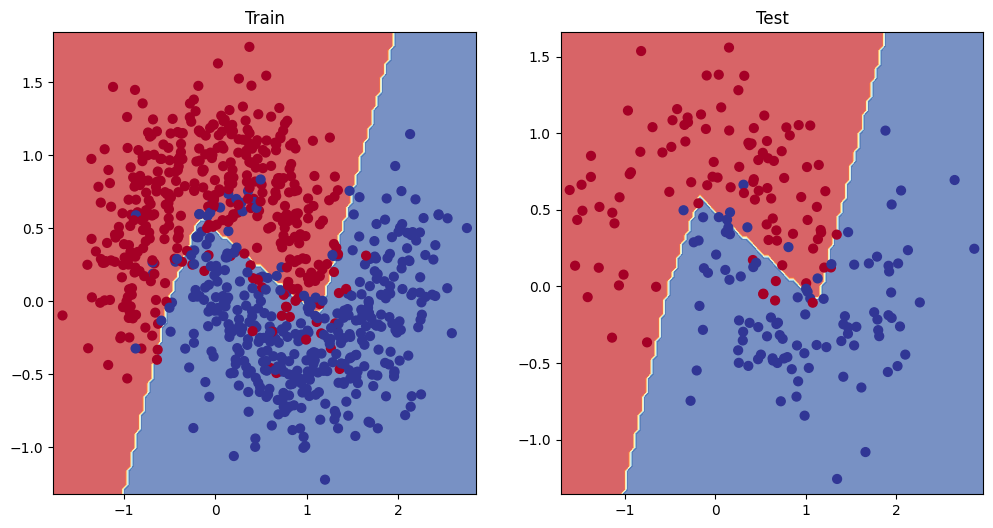

In [46]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [51]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME="binary_classification_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH /MODEL_NAME

print(f"Saving model to :{MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to :models/binary_classification_model_1.pth
